In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import sys
import wordcloud
import spacy
import re

from matplotlib import pyplot as plt
from dotenv import load_dotenv
from collections import Counter

sys.path.append("../")

load_dotenv()
sns.color_palette('colorblind')
plt.style.use('Solarize_Light2')

# Setting default DPI, pulling it from dotenv if it exists, setting it on 100 if not

try:
    pc_dpi = int(os.getenv('DPI'))
except TypeError:
    pc_dpi = 100
if pc_dpi is None:
    pc_dpi = 100


In [2]:
df_text = pd.read_csv(filepath_or_buffer="../data/flipkart_com-ecommerce_sample_1050.csv")


In [3]:
df_text.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [4]:
display(df_text.head(n=5))


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [5]:
display(df_text.isna().sum())


uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

# 1 : First look :

- Looks like `uniq_id` == `image.jpg`, we can drop `uniq_id`.
- `PID` seems irrelevant, as well as `is_FK_Advantage_product`
- `crawl_timestamp` refers to the time at which the product was added to the database via http crawl (best guess), not necessary either
- `product_rating` and `overall_rating` might not be relevant, we'll take a look at those and drop them if its useless
- The price might be indicative of the category (im not expecting a bag of pasta at 5000 dollars or a car at 2.99 $), `discounted price can go`
- `url` will stay as its a metadata and we kinda need it if we are to crawl the database again
- `specifications` look similar to cat tree, we'll take a closer look
- Let's define "main category" as the last category in category tree, will help us for vizs. (tbd.)

<i>Note : Prices are in Rs. (Indian Rupees)</i>


In [6]:
droplist = ["uniq_id", "crawl_timestamp", "pid", "discounted_price", "is_FK_Advantage_product"]


In [7]:
trow = df_text.iloc[[0]]


In [8]:
tree = trow["product_category_tree"].values[0]
print(tree)


["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]


In [9]:
display(trow["product_name"])


0    Elegance Polyester Multicolor Abstract Eyelet ...
Name: product_name, dtype: object

For category tree, it seems that tree[-1] is product name, so we want at least tree[-2] for it to be relevant as category


In [10]:
def category_editor(row):
    category_tree = row["product_category_tree"]
    category_tree = category_tree[2:-2]
    cat_list = category_tree.split(sep=" >> ")
    return cat_list[:-1]


In [11]:
del trow
del tree

df_text["_category_tree"] = df_text.apply(category_editor, axis=1)


In [12]:
display(df_text["_category_tree"].head(n=5))


0    [Home Furnishing, Curtains & Accessories, Curt...
1    [Baby Care, Baby Bath & Skin, Baby Bath Towels...
2    [Baby Care, Baby Bath & Skin, Baby Bath Towels...
3    [Home Furnishing, Bed Linen, Bedsheets, SANTOS...
4    [Home Furnishing, Bed Linen, Bedsheets, Jaipur...
Name: _category_tree, dtype: object

Let's look at some of the other cols. :

In [13]:
df_text["product_specifications"][0]


'{"product_specification"=>[{"key"=>"Brand", "value"=>"Elegance"}, {"key"=>"Designed For", "value"=>"Door"}, {"key"=>"Type", "value"=>"Eyelet"}, {"key"=>"Model Name", "value"=>"Abstract Polyester Door Curtain Set Of 2"}, {"key"=>"Model ID", "value"=>"Duster25"}, {"key"=>"Color", "value"=>"Multicolor"}, {"key"=>"Length", "value"=>"213 cm"}, {"key"=>"Number of Contents in Sales Package", "value"=>"Pack of 2"}, {"key"=>"Sales Package", "value"=>"2 Curtains"}, {"key"=>"Material", "value"=>"Polyester"}]}'

So thats a dict containing many useful infos about the product. We might need to transform the values for it to be readable in python but it seems interesting to keep it.

In [14]:
display(df_text["overall_rating"].describe())

print(f"Rating values : {df_text['overall_rating'].unique()} \n")

print(f"Unrated count : {len(df_text[df_text['overall_rating'] == 'No rating available'])}", )


count                    1050
unique                     27
top       No rating available
freq                      889
Name: overall_rating, dtype: object

Rating values : ['No rating available' '5' '1' '2.3' '2.7' '4.5' '4' '3.8' '4.3' '3.7'
 '3.6' '3.5' '4.1' '4.9' '3.1' '4.2' '4.8' '4.4' '3.9' '3' '3.3' '2.5' '2'
 '4.7' '2.2' '3.2' '1.5'] 

Unrated count : 889


In [15]:
display(df_text["product_rating"].describe())

print(f"Rating values : {df_text['product_rating'].unique()} \n")

print(f"Unrated count : {len(df_text[df_text['product_rating'] == 'No rating available'])}", )


count                    1050
unique                     27
top       No rating available
freq                      889
Name: product_rating, dtype: object

Rating values : ['No rating available' '5' '1' '2.3' '2.7' '4.5' '4' '3.8' '4.3' '3.7'
 '3.6' '3.5' '4.1' '4.9' '3.1' '4.2' '4.8' '4.4' '3.9' '3' '3.3' '2.5' '2'
 '4.7' '2.2' '3.2' '1.5'] 

Unrated count : 889


I don't think the ratings are that useful in this particular use case, dropping both :

In [16]:
droplist.append("product_rating")
droplist.append("overall_rating")


In [17]:
print(droplist)


['uniq_id', 'crawl_timestamp', 'pid', 'discounted_price', 'is_FK_Advantage_product', 'product_rating', 'overall_rating']


In [18]:
df_text = df_text.drop(columns=droplist)


In [19]:
# We have One NaN in retail_price, let's drop it :

df_text.dropna(subset=["retail_price"], inplace=True)
df_text.reset_index(drop=True, inplace=True)


In [20]:
# Another one in product spec, same deal

df_text.dropna(subset=["product_specifications"], inplace=True)
df_text.reset_index(drop=True, inplace=True)


# 2 : NLP Pre cleaning :

Let's clean description a little bit : 
Pipeline will be : 
- filter for :
    - stopwords
    - punctuation
    - non ASCII chars
    - special characters
- actions :
    - Tokenizer
    - Lemmatizer

In [21]:
nlp = spacy.load('en_core_web_lg')


In [22]:
def cleaning_row(row, model):
    """
    Returns list of lemmatized tokens filtered for non ascii, punct, stopwords, digits

    args:
    row : row from dataframe
    model : language model, using spacy

    returns:
    
    accepted_tokens : list of accepted tokens
    """

    accepted_tokens = []
    desc = model(row["description"].lower())
    for token in desc.doc:        
        fil = (
            token.is_ascii and not token.is_punct and not token.is_stop
            and not token.is_digit and token.is_alpha
            )
        if (fil and not bool(re.search(r"\d", token.lemma_))):
            lemd_tk = re.sub(r"[^a-zA-Z0-9 ]", "", token.lemma_)
            if lemd_tk.__len__() > 2:
                accepted_tokens.append(token.lemma_)

    return accepted_tokens


In [23]:
df_text["lem_desc"] = df_text.apply(func=cleaning_row, axis=1, args=[nlp])


In [24]:
df_text["lem_desc"].head()


0    [key, feature, elegance, polyester, multicolor...
1    [specification, sathiyas, cotton, bath, towel,...
2    [key, feature, santosh, royal, fashion, cotton...
3    [key, feature, jaipur, print, cotton, floral, ...
4    [maserati, time, analog, watch, boy, buy, mase...
Name: lem_desc, dtype: object

In [25]:
list_text = df_text["lem_desc"].values.tolist()

lem_list = []

for sublist in list_text:
    for elem in sublist:
        lem_list.append(elem)


In [26]:
df_text["description"].tail()


1043    Oren Empower Extra Large Self Adhesive Sticker...
1044    Wallmantra Large Vinyl Sticker Sticker (Pack o...
1045    Buy Uberlyfe Extra Large Pigmented Polyvinyl F...
1046    Buy Wallmantra Medium Vinyl Sticker Sticker fo...
1047    Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...
Name: description, dtype: object

In [27]:
df_text["lem_desc"].tail()


1043    [oren, empower, extra, large, self, adhesive, ...
1044    [wallmantra, large, vinyl, sticker, sticker, p...
1045    [buy, uberlyfe, extra, large, pigmented, polyv...
1046    [buy, wallmantra, medium, vinyl, sticker, stic...
1047    [buy, uberlyfe, large, vinyl, sticker, online,...
Name: lem_desc, dtype: object

# 3 : Dimensionnal reduction :

- Words that appear only once can go
- Handpicked words which have no particular interest in the context but are common are treated as stopwords


In [28]:
count_tk = Counter(lem_list)

count_tk.most_common(20)


[('product', 860),
 ('free', 618),
 ('buy', 583),
 ('delivery', 567),
 ('genuine', 564),
 ('shipping', 564),
 ('cash', 564),
 ('price', 559),
 ('replacement', 559),
 ('day', 553),
 ('guarantee', 473),
 ('mug', 457),
 ('feature', 404),
 ('online', 396),
 ('design', 368),
 ('color', 368),
 ('watch', 355),
 ('pack', 328),
 ('type', 324),
 ('baby', 321)]

In [29]:
df_words = pd.DataFrame(count_tk.items(), columns=["word", "occurences"])
df_words.sort_values(by="occurences", ascending=False, inplace=True)
df_words.reset_index(drop=True, inplace=True)


In [30]:
# 30 most common :

df_words.head(n=30)


,word,occurences
0,product,860
1,free,618
2,buy,583
3,delivery,567
4,cash,564
5,shipping,564
6,genuine,564
7,price,559
8,replacement,559
9,day,553


In [31]:
# last 10 :

df_words.tail(n=10)


,word,occurences
4004,threadwork,1
4005,maxim,1
4006,sphere,1
4007,gaze,1
4008,tatvaarts,1
4009,boring,1
4010,lightning,1
4011,fascinate,1
4012,ergonomic,1
4013,mocktail,1


In [32]:
# Number of lemmas that appears just once : 

df_words[df_words["occurences"] == 1].__len__()


1155

In [33]:
# Let's remove manually most common which won't bring any meaning :

manual_remove = [
    "product", "free", "buy", "delivery", "feature", "day", "general", "cash",
    "cash", "price", "guarantee", "shipping", "online", "sale", "specification",
    "inch", "ideal", "india", "replacement", "good", "great", "discount"
    ]

# good and great are uninformative, if it is to inform of the quality, not relevant
# India is in the list bcs the site is indian, therefore its too common


In [34]:
df_words = df_words[~df_words["word"].isin(manual_remove)]
df_words = df_words[df_words["occurences"] > 1]
df_words = df_words.reset_index(drop=True)


In [35]:
display(df_words.head(n=10))
print("___________________________")
display(df_words.tail(n=10))


,word,occurences
0,genuine,564
1,mug,457
2,design,368
3,color,368
4,watch,355
5,pack,328
6,type,324
7,baby,321
8,material,305
9,set,301


___________________________


,word,occurences
2828,lack,2
2829,tableware,2
2830,inception,2
2831,insurance,2
2832,diversification,2
2833,appear,2
2834,uber,2
2835,industrial,2
2836,drilling,2
2837,establish,2


In [36]:
df_words.__len__()


2838

In [37]:
keepers = df_words["word"].values.tolist()


In [38]:
wc_data = dict(count_tk)
wc_keys = list(wc_data.keys())
for key in wc_keys:
    if key not in keepers:
        wc_data.pop(key)


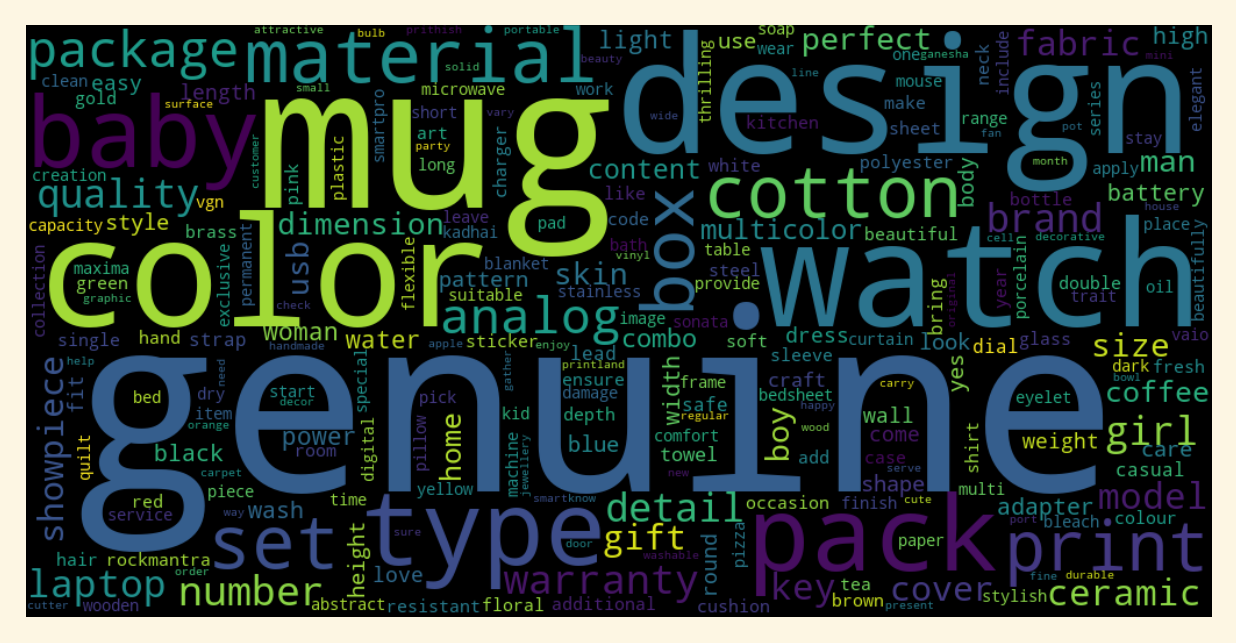

In [39]:
wcloud = wordcloud.WordCloud(width=4*pc_dpi,height=2*pc_dpi, max_words=250,relative_scaling=1)
wcloud.generate_from_frequencies(wc_data)
plt.figure(figsize=(6, 6), dpi=pc_dpi)
plt.imshow(wcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [40]:
def reduce_lex(row, keeplist: list):
    """
    Takes a lemmed row and removes all words not in keeplist
    
    args:
    row : row from dataframe
    keeplist : list of words to keep
    
    returns:
    wordlist : updated word list without words not in keeplist
    """
    word_list = row["lem_desc"]
    accepted_list = []
    for word in word_list:
        if word in keeplist:
            accepted_list.append(word)

    return accepted_list


In [41]:
df_text["lem_desc"] = df_text.apply(func=reduce_lex, axis=1, args=[keepers])


In [42]:
# Check if we have NA descs
df_text["lem_desc"].isna().sum()


0

In [43]:
# We will also keep lemd desc astype spacy.doc for further operations :

def list_to_doc(row):
    desc_list = row["lem_desc"]
    desc_str = " ".join(desc_list)
    return nlp(desc_str)


In [44]:
df_text["doc_desc"] = df_text.apply(func=list_to_doc, axis=1)


In [45]:
df_text.head(1)


,product_url,product_name,product_category_tree,retail_price,image,description,brand,product_specifications,_category_tree,lem_desc,doc_desc
0,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",1899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...","[Home Furnishing, Curtains & Accessories, Curt...","[key, elegance, polyester, multicolor, abstrac...","(key, elegance, polyester, multicolor, abstrac..."


# 4 : Export
- Brand is not useful (it's in specs.)
- We will keep image
- Desc & lem desc are saved
- Price is not useful here
- Category tree is kept (the reworked one)
- Target will be defined as `category_tree[0]`

In [46]:
def get_first_category(row):
    return row["_category_tree"][0].lower()


In [47]:
df_text["first_category"] = df_text.apply(func=get_first_category, axis=1)


In [48]:
keep_cols = [
    "product_name", "doc_desc", "lem_desc", "first_category",
    "product_specifications", "image", "description",  "_category_tree"
    ]

df_export = df_text[keep_cols]
df_export = df_export.rename(columns={"_category_tree" : "category_tree"})


In [49]:
df_export["first_category"].value_counts()


home furnishing               150
watches                       150
kitchen & dining              150
beauty and personal care      150
computers                     150
baby care                     149
home decor & festive needs    149
Name: first_category, dtype: int64

Let's generalize this :

- computers = multimedia
- beauty and personal care = beauty & personal care & health

In [50]:
replace_dict = {
    "computers": "multimedia",
    "beauty and personal care": "beauty & personal care & health"
    }

df_export["first_category"] = df_export["first_category"].replace(to_replace=replace_dict)

df_export["first_category"].value_counts()


home furnishing                    150
watches                            150
kitchen & dining                   150
beauty & personal care & health    150
multimedia                         150
baby care                          149
home decor & festive needs         149
Name: first_category, dtype: int64

Might be an oversimplification but we can proceed the same way into these sub categories, it will require a new model for each subcategory and so on. The target size of 150 is good enough to train a model, we might not have enough data to be accurate in the subsequent sub-categories.

In [51]:
df_export.to_pickle(path="../data/ecommerce_cleaned.pkl")


In [52]:
df_export.columns


Index(['product_name', 'doc_desc', 'lem_desc', 'first_category',
       'product_specifications', 'image', 'description', 'category_tree'],
      dtype='object')